# **Klasifikace dat Sentinel-2**
## 155UZPR - Katedra Geomatiky - Fsv ČVUT
### Tereza Černohousová - Matěj Klimeš
### ZS2024

**Abstrakt:** Projekt se bude zabývat automatickým stažením dat Sentinel-2, jejich předzpracováním (včetně výpočtu spektrálních indexů) a následnou klasifikací a vizualizací výsledků.

#### Zadání od uživatele

In [307]:
# Název zájmové obce
obec_zajmu = "Žamberk"

# Jaký produkt Sentinel chceme
product = "S2_MSI_L2A" 

# Pro jaké období chce najít snímmky
start = "2024-10-01"
end = "2024-10-23"

# Přihlašovací údaje pro Copernicus
username = "cernote2@cvut.cz"
password = "Copernicus*2024UZPR"

#### Import knihoven

In [308]:
import fiona
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib.request
import folium
import mapclassify
import zipfile
import shapely
import os
from eodag import EODataAccessGateway
import numpy as np
import rasterio as rio
import rasterio.mask as mask
from sklearn.cluster import KMeans 

#### Stažení data250 pro stanovení oblasti zájmu

In [309]:
# Cílový adresář
zip_filename = "data250.zip"
# URL se zdrojem dat .shp
url = "https://openzu.cuzk.cz/opendata/Data250/epsg-5514/data250.zip"

# Stažení souboru ZIP pouze pokud dosud neexistuje
if not os.path.exists(zip_filename):  # Kontrola, zda soubor již existuje
    print(f"ZIP soubor {zip_filename} neexistuje, stahuji data...")  # Informace o stahování
    urllib.request.urlretrieve(url, zip_filename)  # Stažení souboru z dané URL
    print(f"Soubor {zip_filename} byl úspěšně stažen.")  # Potvrzení úspěšného stažení
else:
    print(f"ZIP soubor {zip_filename} již existuje. Stažení přeskočeno.")  # Informace o přeskakování stahování


ZIP soubor data250.zip již existuje. Stažení přeskočeno.


#### Import vrstvi obcí ze staženého ZIPu

In [75]:
obce = gpd.read_file("data250.zip!/PolbndMunDA.shp")
obce.head()

,FCSUBTYPE,F_CODE,ICC,SHN0,SHN1,SHN2,SHN3,TAA,ICOB,NUTS3,ISN,NAMN,DESN,SHAPE_Leng,SHAPE_Area,geometry
0,1,FA001,CZ,CZ0000000000,CZ0100000000,UNK,CZ0100554782,1,554782,CZ010,4605,Praha,obec,157071.726075,4.963111e+08,"POLYGON ((-733582.756 -1034199.856, -733690.30..."
1,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201513482,1,513482,CZ020,4605,Vysoký Újezd,obec,13689.999181,4.064693e+06,"POLYGON ((-742125.829 -1072463.392, -742056.67..."
2,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201529303,1,529303,CZ020,4605,Benešov,obec,54242.943513,4.682135e+07,"POLYGON ((-729711.586 -1073957.287, -729679.83..."
3,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201529451,1,529451,CZ020,4605,Bystřice,obec,64917.905895,6.343932e+07,"POLYGON ((-730989.011 -1081012.603, -731007.23..."
4,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201529478,1,529478,CZ020,4605,Čakov,obec,13297.559487,5.318608e+06,"POLYGON ((-716606.98 -1075299.75, -716493.11 -..."


#### Výběr geometrie pro zadanou oblast

In [310]:
aoi = obce[obce["NAMN"] == obec_zajmu]["geometry"]

#### Zobrazení oblasti

<Axes: title={'center': 'Hranice obce: Žamberk'}>

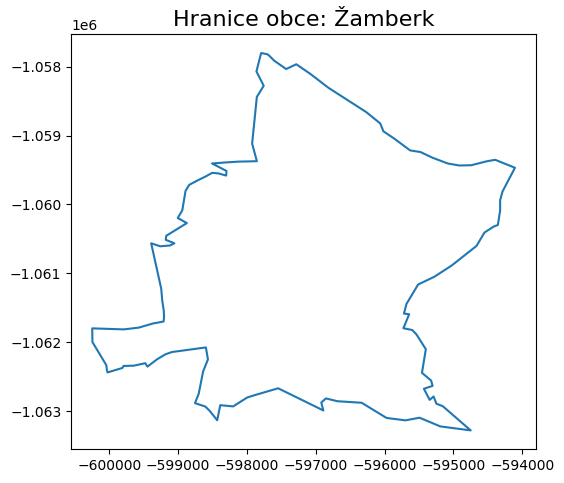

In [311]:
# Vytvoření grafu
fig, ax = plt.subplots(figsize=(6, 6))

# Nastavení názvu grafu s názvem obce
ax.set_title(f"Hranice obce: {obec_zajmu}", fontsize=16)

# Načtení a vykreslení hranic obce z objektu 'aoi' na daný graf
aoi.boundary.plot(ax=ax)


#### Nastavení souřadnicového systému na S-JTSK

In [312]:
# Nastavení souřadnicového systému pro objekty v 'aoi' na EPSG:5514
aoi_map = aoi.set_crs(epsg=5514)

# Zobrazení hranic obce pomocí interaktivního nástroje 'explore'
aoi_map.boundary.explore()


## Prace se SENTINEL

In [313]:
# Vytvoření instance třídy EODataAccessGateway pro přístup k datům
dag = EODataAccessGateway()
# Získání dostupných poskytovatelů dat pro specifikovaný produkt
dag.available_providers(product)


['astraea_eod',
 'cop_dataspace',
 'creodias',
 'onda',
 'planetary_computer',
 'sara']

#### Vyhledání dat pro parametry zadané uživatelem

In [80]:
# Převod geometrie oblasti zájmu (AOI) na souřadnicový systém EPSG:4326 (WGS 84)
# a získání celkových hranic (bounding box) této oblasti ve formě n-tice
extent = tuple(aoi_map.to_crs(4326).total_bounds)

# Zobrazení hodnoty proměnné 'extent' (hranice AOI v souřadnicovém systému EPSG:4326)
extent

# Nastavení preferovaného poskytovatele dat na 'cop_dataspace'
dag.set_preferred_provider("cop_dataspace")

# Vyhledávání dat podle specifikovaných parametrů
results = dag.search(
    productType=product,  # Typ produktu (např. satelitní snímek)
    start=start,  # Začátek časového intervalu
    end=end,  # Konec časového intervalu
    geom=tuple(extent),  # Geometrie vyhledávání ve formě hranic AOI
    count=True  # Počet výsledků
)

# Výpis počtu nalezených záznamů (produktů) odpovídajících vyhledávání
print(results.number_matched)


14


#### Nalezené produkty

In [314]:
results_cc = results.filter_property(operator="le", cloudCover=15) #puvodne 5 pro Katovice
results_cc

SearchResult([EOProduct(id=S2B_MSIL2A_20241016T100029_N0511_R122_T33UXR_20241016T161420, provider=cop_dataspace)])

#### Úprava konfiguračního souboru

In [87]:
dag.update_providers_config(f"""
cop_dataspace:  
    download:  
        extract: False
        outputs_prefix: /tmp/sentinel  
        delete_archive: False  

    auth:  
        credentials:  
            username: {username}  
            password: {password}
""")


#### Vizualizace dat před stažením

quicklooks/S2B_MSIL2A_20241016T100029_N0511_R122_T33UXR_20241016T161420: 0.00B [00:00, ?B/s]


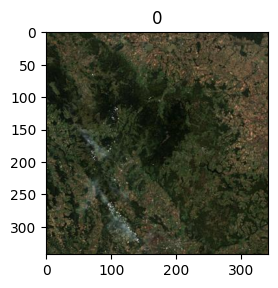

In [315]:
# Vytvoření obrázku pro zobrazení více snímků
fig = plt.figure(figsize=(10, 8))  # Velikost obrázku (šířka 10, výška 8)

# Procházíme seznam 'results_cc', který obsahuje produkty (např. satelitní snímky)
for i, product in enumerate(results_cc, start=1):  # Začínáme indexovat od 1
    # Tato řádka se stará o stažení náhledového obrázku (quicklook) pro každý produkt
    quicklook_path = product.get_quicklook()  # Získání cesty k náhledovému obrázku

    # Načtení a zobrazení obrázku
    img = mpimg.imread(quicklook_path)  # Načteme obrázek z dané cesty
    ax = fig.add_subplot(3, 4, i)  # Vytvoříme podgraf v mřížce 3x4, pozice podle indexu 'i'

    # Nastavení titulku podgrafu, kde začínáme od 0
    ax.set_title(i - 1)  

    # Zobrazení obrázku v příslušném podgrafu
    plt.imshow(img)

# Úprava rozvržení pro správné zobrazení obrázků, aby se nepřekrývaly
plt.tight_layout()  


#### Stažení prvního produktu z nalezených

In [89]:
# Importujeme třídu Path z modulu pathlib pro práci s cestami k souborům
from pathlib import Path

# Stahujeme data pro první produkt v seznamu results_cc
data_path = dag.download(results_cc[0])  # Zavolání metody pro stažení dat

#print(data_path, Path(data_path).exists())


0.00B [00:00, ?B/s]
S2B_MSIL2A_20241016T100029_N0511_R122_T33UXR_20241016T161420: 0.00B [00:00, ?B/s]
S2B_MSIL2A_20241016T100029_N0511_R122_T33UXR_20241016T161420: 0file [00:00, ?file/s]
S2B_MSIL2A_20241016T100029_N0511_R122_T33UXR_20241016T161420: 100%|███████████████████| 1/1 [00:00<00:00, 161.18file/s]


In [90]:
#data_path = "C:\Users\terce\AppData\Local\Temp\S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806.SAFE.zip"
#data_path = "C:\Users\terce\AppData\Local\Temp\S2B_MSIL2A_20241016T100029_N0511_R122_T33UXR_20241016T161420.SAFE.zip"

#### Funkce pro výpočet různých spektrálních indexů (NDVI, NDWI, NDMI, AWEISh)

In [347]:
def SpectralIndexes(si, data_path, clip_polygon, clip_polygon_name):
    # Importujeme potřebné knihovny
    import rasterio.mask as mask  # Pro maskování rastrů
    from rasterio.enums import Resampling  # Pro resamplování (převzorkování) dat
    from rasterio.io import MemoryFile  # Pro práci s virtuálními soubory v paměti

    # Inicializace subdatasetů (načítání dat Sentinel-2)
    with rio.open(data_path) as ds:
        sd = ds.subdatasets  # Seznam dostupných subdatasetů (pásma) v datech Sentinel-2

   # # Vytisknutí informací o páskách Sentinel-2
   # print('Informace o datech Sentinel-2:')
   # for i in range(0, 2):  # Procházíme prvními 2 subdatasety (pásma)
   #     print('Subdataset:', i)
   #     with rio.open(sd[i]) as subds:
   #         sd_crs = subds.crs.to_epsg()  # Extrahujeme CRS (systém souřadnic) z dat
   #         for b in subds.indexes:  # Procházíme každé pásmo v subdatasetu
   #             print(b, subds.tags(b)['BANDNAME'])  # Vytiskneme číslo pásma a jeho název
                
    # Oříznutí dat podle oblasti zájmu (AOI) pro první subdataset
    crop_sen_clip0, out_transform0 = crop_band(sd[0], aoi)
    crop_sen_clip1, out_transform1 = crop_band(sd[0], aoi)

    # Extrakce specifických pásem pro výpočty z oříznutých datasetů
    R = crop_sen_clip0[0]  # Červené pásmo (B4)
    G = crop_sen_clip0[1]  # Zelené pásmo (B3)
    B = crop_sen_clip0[2]  # Modré pásmo (B2)
    NIR = crop_sen_clip0[3]  # Pásmo blízké infračervené (B8)

    SWIR1 = crop_sen_clip1[4]  # Pásmo krátkovlnného infračerveného záření 1 (B11)
    SWIR2 = crop_sen_clip1[5]  # Pásmo krátkovlnného infračerveného záření 2 (B12)

    # Resamplování SWIR1 tak, aby odpovídalo rozlišení pásma NIR
    target_height, target_width = NIR.shape  # Získáme cílové rozlišení (výška a šířka) z pásma NIR
    with MemoryFile() as memfile:
        with memfile.open(
            driver="GTiff",
            height=SWIR1.shape[0],
            width=SWIR1.shape[1],
            count=1,
            dtype=SWIR1.dtype,
            transform=out_transform1
        ) as dataset:
            dataset.write(SWIR1, 1)  # Zapíšeme pásmo SWIR1 do virtuálního souboru

            # Resamplování SWIR1 tak, aby odpovídalo rozlišení NIR pomocí bilineární interpolace
            swir1_resampled = dataset.read(
                1,
                out_shape=(target_height, target_width),
                resampling=Resampling.bilinear
            )
   
    # Resamplování pásma SWIR1 a SWIR2 tak, aby odpovídalo rozlišení NIR
    target_height, target_width = NIR.shape
    SWIR1 = resample_band(SWIR1, out_transform1, target_height, target_width)
    SWIR2 = resample_band(SWIR2, out_transform1, target_height, target_width)
    
    # VÝPOČET INDEXU na základě zvoleného spektrálního indexu (si)
    if si == 'NDVI':  # Výpočet NDVI (Normalized Difference Vegetation Index)
        raster = (NIR - R) / (NIR + R)
    elif si == 'NDWI':  # Výpočet NDWI (Normalized Difference Water Index)
        raster = (G - NIR) / (G + NIR)
    elif si == 'NDMI':  # Výpočet NDMI (Normalized Difference Moisture Index)
        raster = (NIR - SWIR1) / (NIR + SWIR1)
    elif si == 'AWEISH':  # Výpočet AWEISH (Automated Water Extraction Index for Shadow)
        raster = B + 2.5 * G - 1.5 * (NIR + SWIR1) - 0.25 * SWIR2

    # Zobrazení výsledku výpočtu spektrálního indexu jako teplotní mapy
    #plt.imshow(raster, cmap='RdYlGn')  # Zobrazíme vypočítaný spektrální index jako obrázek
    #plt.suptitle(si)  # Titulek grafu: název spektrálního indexu
    #plt.title(clip_polygon_name)  # Podtitulek: název oříznuté oblasti (polygonu)
    #plt.colorbar()  # Zobrazíme barevnou škálu
    return raster  # Vrátíme vypočítaný rastr (spektrální index)


#### Funkce pro oříznutí jednotlivých pásem

In [319]:
def crop_band(data_path, polygon):
    """
    Ořízne pásmo Sentinel-2 dat podle zadaného polygonu.

    Parametry:
    - data_path (str): Cesta k Sentinel-2 datům (jednotlivému pásmu/subdatasetu).
    - polygon (GeoDataFrame): Polygon definující oblast zájmu (AOI).

    Návratová hodnota:
    - cropped_data (ndarray): Oříznuté pásmo jako numpy pole.
    - out_transform (Affine): Transformace oříznutého rastru.
    """
    # Načtení pásma Sentinel-2
    with rio.open(data_path) as src:
        # Transformace polygonu na CRS pásma
        polygon = polygon.to_crs(src.crs)
        # Oříznutí dat podle polygonu
        cropped_data, out_transform = mask.mask(src, shapes=polygon.geometry, crop=True, filled=True)
        # Převedení nodata hodnot na NaN
        cropped_data = cropped_data.astype(float)
        cropped_data[cropped_data == 0] = np.nan    
    return cropped_data, out_transform



#### Funkce pro převzorkování pásem s jiným rozlišením

In [320]:
def resample_band(band, out_transform, target_height, target_width):
    # Importujeme potřebné knihovny
    from rasterio.io import MemoryFile  # Pro práci s virtuálními soubory v paměti
    import rasterio.mask as mask  # Pro maskování rastrů
    from rasterio.enums import Resampling  # Pro metody resamplování (převzorkování) dat
    
    # Vytvoření virtuálního souboru pro zápis pásma
    with MemoryFile() as memfile:
        with memfile.open(
            driver="GTiff",  # Formát souboru (GeoTIFF)
            height=band.shape[0],  # Výška pásma (počet řádků)
            width=band.shape[1],  # Šířka pásma (počet sloupců)
            count=1,  # Počet kanálů (v tomto případě 1, protože máme jen jedno pásmo)
            dtype=band.dtype,  # Datový typ dat v pásmu
            transform=out_transform,  # Georeferencování (transformace) pásma
        ) as dataset:
            dataset.write(band, 1)  # Zapíšeme pásmo do virtuálního souboru

            # Resamplování pásma tak, aby odpovídalo cílovému rozlišení
            resampled_band = dataset.read(
                1,
                out_shape=(target_height, target_width),  # Cílové rozměry
                resampling=Resampling.bilinear,  # Použití bilineární interpolace pro převzorkování
            )
    
    return resampled_band  # Vrátíme resamplované pásmo


## Spektrální indexy 

C:\Users\terce\venv-uzpr\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\terce\venv-uzpr\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\terce\venv-uzpr\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
C:\Users\terce\venv-uzpr\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(np.float64(-0.5), np.float64(579.5), np.float64(537.5), np.float64(-0.5))

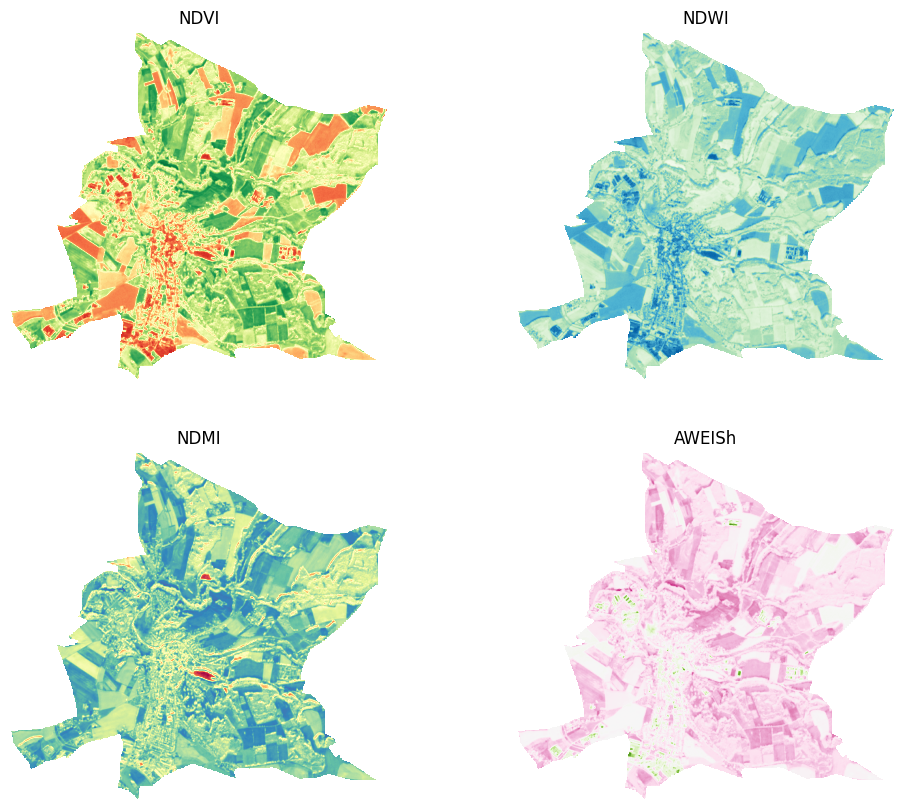

In [362]:
NDVI = SpectralIndexes('NDVI', data_path, aoi, obec_zajmu)
NDWI = SpectralIndexes('NDWI', data_path, aoi, obec_zajmu)
NDMI = SpectralIndexes('NDMI', data_path, aoi, obec_zajmu)
AWEISh = SpectralIndexes('AWEISH', data_path, aoi, obec_zajmu)

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
# 1 subplot
ax[0, 0].imshow(NDVI, cmap='RdYlGn')
ax[0, 0].set_title('NDVI')
ax[0, 0].axis('off')  # Skrytí os pro lepší vzhled

# 2 subplot
ax[0, 1].imshow(NDWI, cmap = 'GnBu')
ax[0, 1].set_title('NDWI')
ax[0, 1].axis('off')  # Skrytí os pro lepší vzhled

# 3 subplot
ax[1, 0].imshow(NDMI,cmap = 'Spectral')
ax[1, 0].set_title('NDMI')
ax[1, 0].axis('off')  # Skrytí os pro lepší vzhled

# 4 subplot
ax[1, 1].imshow(AWEISh,cmap = 'PiYG')
ax[1, 1].set_title('AWEISh')
ax[1, 1].axis('off')  # Skrytí os pro lepší vzhled



## Neřízená klasifikace

In [95]:
# Cesta k ZIPu s daty Sentinel-2
#data_path = "S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806.SAFE.zip"
#data_path = r"C:\Users\terce\AppData\Local\Temp\S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806.SAFE.zip"
# Otevření
with rio.open(data_path) as ds:
    # Načteme seznam subdatasetů (pásma) z dat Sentinel-2
    sd = ds.subdatasets  # Seznam dostupných subdatasetů v datech Sentinel-2
    meta = ds.meta    
print(meta)
print(len(sd), sd[0])

{'driver': 'SENTINEL2', 'dtype': 'float_', 'nodata': None, 'width': 512, 'height': 512, 'count': 0, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}
4 SENTINEL2_L2A:/vsizip/C:\Users\terce\AppData\Local\Temp\S2B_MSIL2A_20241016T100029_N0511_R122_T33UXR_20241016T161420.SAFE.zip/S2B_MSIL2A_20241016T100029_N0511_R122_T33UXR_20241016T161420.SAFE/MTD_MSIL2A.xml:10m:EPSG_32633


C:\Users\terce\venv-uzpr\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Výpis informací o datech s rozlišením 10 m

In [96]:
with rio.open(sd[0]) as b10m:
    print("CRS:", b10m.crs)
    print("Bounds:", b10m.bounds)
    print("Bands:", b10m.count)
    meta = b10m.meta
    for b in b10m.indexes:
        print(b, b10m.tags(b)["BANDNAME"])

CRS: EPSG:32633
Bounds: BoundingBox(left=600000.0, bottom=5490240.0, right=709800.0, top=5600040.0)
Bands: 6
1 B4
2 B3
3 B2
4 B8
5 AOT
6 WVP


Převod SS zájmové oblasti na SS dat Sentinel

In [97]:
aoi_utm = aoi_map.to_crs(epsg=32633)
print(aoi_utm)

3932    POLYGON ((604366.529 5552509.363, 604469.737 5...
Name: geometry, dtype: geometry


Funkce na ořez rastru dle aoi

In [223]:
def clip_raster(data_path, aoi):
    with rio.open(data_path) as ds:
        with rio.open(ds.subdatasets[0]) as b10m:
            image, transform = rio.mask.mask(b10m, aoi, crop=True)
            data = image.astype(float)
            return data, transform


data_aoi, clip_transform = clip_raster(data_path, aoi_utm)
data_aoi.shape, clip_transform

C:\Users\terce\venv-uzpr\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


((6, 538, 580),
 Affine(10.0, 0.0, 602340.0,
        0.0, -10.0, 5552520.0))

Procházení dat

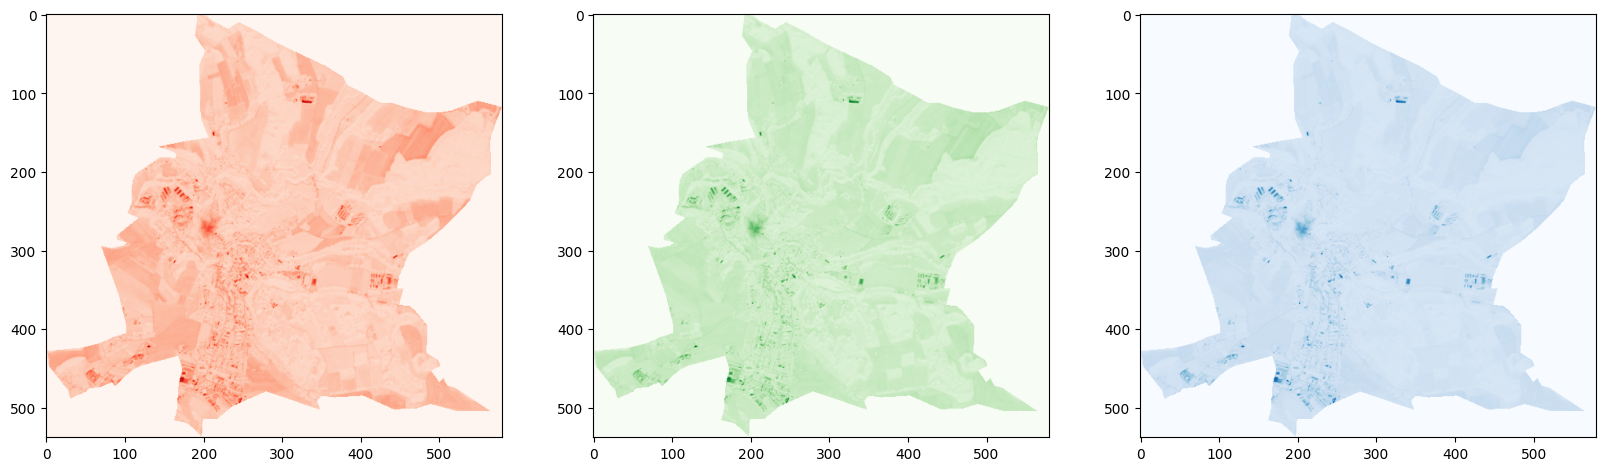

In [224]:
red = data_aoi[0, :, :]
green = data_aoi[1, :, :]
blue = data_aoi[2, :, :]
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(red, cmap='Reds')
ax1 = fig.add_subplot(1,3,2)
ax1.imshow(green, cmap='Greens')
ax1 = fig.add_subplot(1,3,3)
ax1.imshow(blue, cmap='Blues')

# Normalizace hodnot do rozsahu 0-1 pro vizualizaci
def normalize(band):
    # Normalizace do rozsahu 0-1
    return (band - band.min()) / (band.max() - band.min())

r_norm = normalize(red)
g_norm = normalize(green)
b_norm = normalize(blue)

RGB mozaika

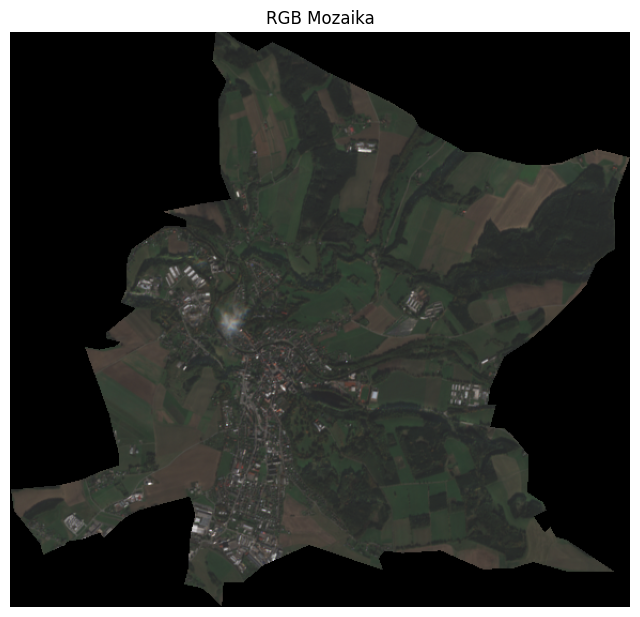

In [225]:
# Kombinace pásem do jednoho RGB obrazu
rgb_image = np.dstack([r_norm, g_norm, b_norm])
# Zobrazení výsledného obrazu
plt.figure(figsize=(8, 8))
plt.imshow(rgb_image)
plt.axis('off')
plt.title("RGB Mozaika")
plt.show()

In [226]:
## Otevření prvního subdatasetu (pásmo) a načtení všech pásem
#with rio.open(sd[0]) as subds:
#    # Oříznutí dat podle masky
#    out_image, out_transform = rio.mask.mask(subds, aoi_utm.geometry, crop=True)
#    nodata_value = 0  # Nebo jiná hodnota, kterou identifikuješ jako pozadí
#    out_image = np.where(out_image == nodata_value, np.nan, out_image)    
#    bands = []
#    # Načtení všech pásem z oříznutých dat
#    for i in range(1, subds.count + 1):
#        band = out_image[i - 1]  # Pásma v oříznutých datech
#        bands.append(band)
#    # Stack všech pásem do 3D pole
#    data = np.stack(bands)
#    
## Nastavíme hodnoty mimo oblast AOI na NaN
#
## Převod dat na 2D matici a odstranění NaN hodnot
#data_2d = data.reshape(data.shape[0], -1).T  # Přeformátujeme data na 2D
#mask_valid = ~np.isnan(data_2d).any(axis=1)  # Vytvoříme masku platných dat (bez NaN)
#data_2d_valid = data_2d[mask_valid]  # Aplikujeme masku
#
## Inicializace K-means
#n_clusters = 5
#kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#
## Fit modelu na platných datech
#kmeans.fit(data_2d_valid)
#
## Získání výsledků a vytvoření klasifikovaného obrazu
#labels = np.full(data_2d.shape[0], np.nan)  # Inicializace výsledků s NaN
#labels[mask_valid] = kmeans.labels_  # Přiřazení výsledků pouze platným datům
#labels_2d = labels.reshape(data.shape[1], data.shape[2])  # Převod zpět na 2D
#
## Zobrazení výsledného klasifikovaného obrazu
#plt.imshow(labels_2d, cmap="viridis")
#plt.colorbar()
#plt.title("K-means klasifikace Sentinel-2 dat")
#plt.show()


#### Oříznutí dat podle zadaného území a nastení všech pásem

In [227]:
# Otevření prvního subdatasetu (pásmo) a načtení všech pásem
with rio.open(sd[0]) as subds:
    # Oříznutí dat podle masky
    out_image, out_transform = rio.mask.mask(subds, aoi_utm.geometry, crop=True)
    nodata_value = 0  # Nebo jiná hodnota, kterou identifikuješ jako pozadí
    out_image = np.where(out_image == nodata_value, np.nan, out_image)    
    bands = []
    # Načtení všech pásem z oříznutých dat
    for i in range(1, subds.count + 1):
        band = out_image[i - 1]  # Pásma v oříznutých datech
        bands.append(band)
    # Stack všech pásem do 3D pole
    data = np.stack(bands)
    
# Nastavíme hodnoty mimo oblast AOI na NaN

# Převod dat na 2D matici a odstranění NaN hodnot
data_2d = data.reshape(data.shape[0], -1).T  # Přeformátujeme data na 2D
mask_valid = ~np.isnan(data_2d).any(axis=1)  # Vytvoříme masku platných dat (bez NaN)
data_2d_valid = data_2d[mask_valid]  # Aplikujeme masku


#with rio.open(sd[0]) as subds:
#    bands = []  # Seznam pro uchování jednotlivých pásem
#    # Načteme všechna pásma v subdatasetu
#    for i in range(1, subds.count + 1):  # Procházení všech pásem v subdatasetu
#        band = subds.read(i)  # Načteme jedno pásmo
#        bands.append(band)  # Přidáme pásmo do seznamu
#    # Převod seznamu pásem na numpy pole (tvar: [pásma, výška, šířka])
#    data = np.stack(bands)  # Stack všech pásem do 3D pole

# Převod dat na 2D matici (tvar: [počet pixelů, počet pásem])
#data_2d = data.reshape(data.shape[0], -1).T  # Přeformátujeme data na 2D (každý pixel v jednom řádku)

#### Neřízená klasifikace pomocí KMeans

In [300]:
# Počet klastrů
#n_clusters = 5  # Např. voda, vegetace, město, zemědělská půda
#
## Inicializace K-means
#kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#
## fit modelu na datech
#kmeans.fit(data_2d)
#
## Získání výsledných tříd (tvar: [počet pixelů])
#labels = kmeans.labels_

# Inicializace K-means
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit modelu na platných datech
kmeans.fit(data_2d_valid)
# Získání výsledků a vytvoření klasifikovaného obrazu
labels = np.full(data_2d.shape[0], np.nan)  # Inicializace výsledků s NaN
labels[mask_valid] = kmeans.labels_  # Přiřazení výsledků pouze platným datům


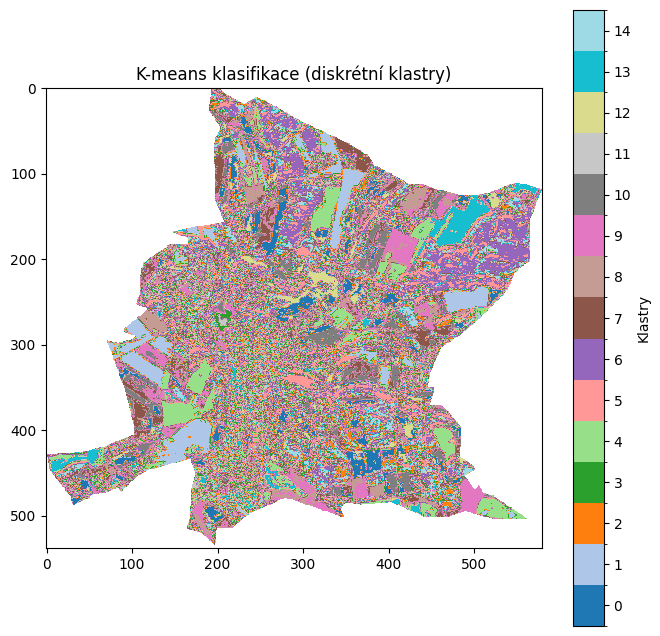

In [301]:
## Převod výsledků zpět na 2D obraz (tvar: [výška, šířka])
#labels_2d = labels.reshape(data.shape[1], data.shape[2])
## Zobrazení klasifikovaného obrazu
#plt.imshow(labels_2d)  # Tab10 je barevná mapa
#plt.colorbar()
#plt.title("K-means klasifikace Sentinel-2 dat")
#plt.show()
from matplotlib.colors import BoundaryNorm
labels_2d = labels.reshape(data.shape[1], data.shape[2])  # Převod zpět na 2D

## Zobrazení výsledného klasifikovaného obrazu
#plt.imshow(labels_2d, cmap="viridis")
#plt.colorbar()
#plt.title("K-means klasifikace Sentinel-2 dat")
#plt.show()

# Definice diskrétní colormap pro n klastrů

cmap = plt.colormaps['tab20']  # Použití palety s n_klastry
cmap = ListedColormap(cmap(np.linspace(0, 1, n_clusters)))

# Normalizace pro diskrétní hodnoty
norm = BoundaryNorm(boundaries=np.arange(n_clusters+1)-0.5, ncolors=n_clusters)

# Vykreslení mapy s colorbarem
plt.figure(figsize=(8,8))
plt.imshow(labels_2d, cmap=cmap, norm=norm)
plt.colorbar(label='Klastry', ticks=np.arange(n_clusters))

# Titulek
plt.title('K-means klasifikace (diskrétní klastry)')
plt.show()


In [178]:
#aoi_wgs = aoi_map.to_crs(32633)
#print(aoi_wgs)

In [179]:
#with rio.open(sd[0]) as b10m_raster:  # Načteme první pásmo
#    # Převeďte AOI na správný formát geometrie
#    geometry = [shapely.geometry.mapping(geom) for geom in aoi_wgs.geometry]
#
#    # Oříznutí rastru podle AOI
#    out_image, out_transform = rio.mask.mask(b10m_raster, geometry, crop=True)
#
#    # Výstupní obrázek po oříznutí
#    print(out_image.shape)

In [180]:
#plt.figure(figsize=(10, 10))
#plt.imshow(out_image[0])  # Předpokládáme, že out_image je 3D pole (pásmo, výška, šířka)
#plt.colorbar(label='Hodnoty pixelů')
#plt.title('Oříznutý raster dle AOI')
#plt.xlabel('Šířka')
#plt.ylabel('Výška')
#plt.show()

In [239]:
## Otevření prvního subdatasetu pro získání metadat
#with rio.open(sd[0]) as subds1:
#    meta = subds1.meta  # Získáme metadata prvního pásma (včetně informací jako rozlišení, CRS, atd.)
#
## Aktualizujeme metadata pro výstupní soubor
#meta.update({
#    "driver": 'GTiff',  # Nastavíme formát souboru na GeoTIFF
#    "dtype": "int8",  # Nastavíme datový typ na 8bitové celé číslo (pro klasifikované hodnoty)
#    "height": labels_2d.shape[0],  # Výška obrázku podle tvaru 2D pole s klasifikovanými hodnotami
#    "width": labels_2d.shape[1],  # Šířka obrázku podle tvaru 2D pole s klasifikovanými hodnotami
#    # "transform": labels_2d.crs(), # TODO: Dodat funkci pro získání transformace a oříznutí CRS
#    "nodata": 0  # Nastavení hodnoty pro NoData (0)
#})
#
## Načteme všechny hodnoty NaN a nahradíme je nulami (NoData hodnoty)
#np.nan_to_num(labels_2d, copy=False)
#
## Vytvoření výstupního GeoTIFF souboru s klasifikovanými hodnotami
#with rio.open('KMeans_Classif.tif', 'w', **meta) as dst:
#   # Zápis klasifikovaných hodnot do souboru (v tomto případě do prvního pásma)
#   dst.write_band(1, labels_2d.astype(rio.int8))  # Převedeme hodnoty na typ int8 a zapíšeme je do souboru



# Ujistíme se, že hodnoty NaN byly nahrazeny hodnotou NoData (např. 0)
#labels_2d = np.nan_to_num(labels_2d, nan=0)  # Nahradíme NaN hodnoty hodnotou 0 (NoData)
#
## Aktualizujeme metadata pro výstupní soubor
#meta.update({
#    "driver": 'GTiff',  # Formát souboru
#    "dtype": "int8",  # Datový typ
#    "height": labels_2d.shape[0],  # Výška obrázku
#    "width": labels_2d.shape[1],  # Šířka obrázku
#    "nodata": 0  # Hodnota pro NoData
#})
#
## Vytvoření výstupního GeoTIFF souboru s klasifikovanými hodnotami
#with rio.open('KMeans_Classif.tif', 'w', **meta) as dst:
#   # Zápis klasifikovaných hodnot do souboru
#   dst.write_band(1, labels_2d.astype('int8'))



In [188]:
## Cesta k již existujícímu klasifikovanému GeoTIFF souboru
#classifTif = 'KMeans_Classif.tif'
#
## Otevření klasifikovaného souboru pomocí knihovny rasterio
#with rio.open(classifTif) as neco:
#    # Načtení prvního pásma z klasifikovaného souboru (pásmo s klasifikovanými hodnotami)
#    classified = neco.read(1)  # Čteme první pásmo (které obsahuje klasifikované hodnoty)
#
## Zobrazení klasifikovaných dat pomocí matplotlib
#plt.imshow(classified)  # Vykreslí klasifikované hodnoty jako obraz
#plt.colorbar()  # Přidá barevnou škálu pro zobrazení hodnot
#plt.title('KMeans Klasifikace')  # Přidá titulek pro obrázek
#plt.show()  # Zobrazí obrázek s klasifikovanými hodnotami


# Otevření klasifikovaného souboru pomocí knihovny rasterio
#with rio.open(classifTif) as src:
#    classified = src.read(1)  # Čteme první pásmo (které obsahuje klasifikované hodnoty)
#    nodata_value = src.nodata  # Získáme hodnotu NoData
#
## Maskování hodnot NoData (pokud existují)
#if nodata_value is not None:
#    classified = np.ma.masked_equal(classified, nodata_value)
#
## Zobrazení klasifikovaných dat
#plt.imshow(classified, cmap="viridis")  # Používáme správnou barevnou mapu
#plt.colorbar()
#plt.title('KMeans Klasifikace')
#plt.show()


#### Maskování pomocí NDVI

In [287]:
# 3. Vytvoření masek na základě NDVI
maska_voda = (NDVI >= -1) & (NDVI < 0)
maska_puda = (NDVI >= 0) & (NDVI < 0.3)
maska_stredni_vegetace = (NDVI >= 0.3) & (NDVI < 0.5)
maska_husta_vegetace = (NDVI >= 0.5) & (NDVI <= 1)

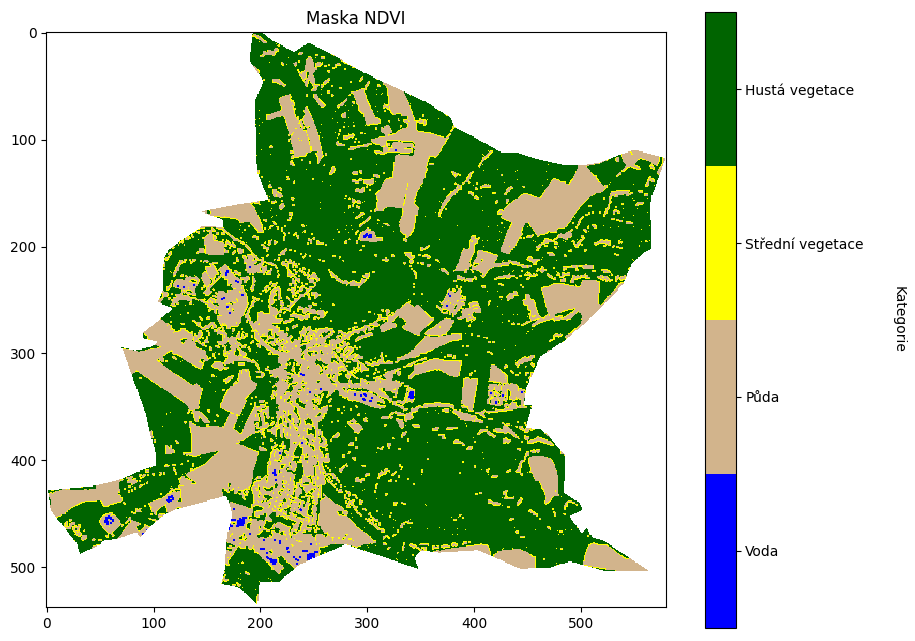

In [288]:
# 2. Vytvoření kombinovaného rastru
# Použijeme hodnoty v labels_2d a přidáme informaci z NDVI masek
#combined_raster = np.full_like(NDVI, -2, dtype=np.int8)
combined_raster = np.full_like(NDVI, np.nan, dtype=np.float32)
# Naplnění kombinovaného rastru na základě masek NDVI
combined_raster[maska_voda] = 1  # Voda
combined_raster[maska_puda] = 2  # Půda
#combined_raster[maska_ridka_vegetace] = 3  # Řídká vegetace
combined_raster[maska_stredni_vegetace] = 4  # Střední vegetace
combined_raster[maska_husta_vegetace] = 5  # Hustá vegetace
clip_raster

from matplotlib.colors import ListedColormap
# 1. Definice vlastní barevné mapy pro 5 kategorií
colors = ['blue', 'tan', 'yellow', 'darkgreen']
#colors = ['white', 'blue', 'tan', 'yellow', 'darkgreen'] 
cmap = ListedColormap(colors)

## 2. Zobrazení kombinovaného rastru
#plt.figure(figsize=(10, 8))
#im = plt.imshow(combined_raster, cmap=cmap)
#plt.colorbar(ticks=[1, 2, 3, 4], label='Kategorie (NDVI a klasifikace)')
#plt.title("Kombinovaný raster NDVI a klasifikace")
#plt.show()
## Přidání barevné legendy
#cbar = plt.colorbar(im, ticks=[1, 2, 3, 4])  # Ticks podle hodnot v kombinovaném rastru
#cbar.set_label('Kategorie (NDVI a klasifikace)', rotation=270, labelpad=15)
#cbar.set_ticklabels(['Voda', 'Půda', 'Střední vegetace', 'Hustá vegetace'])  # Názvy kategorií

# Zobrazení kombinovaného rastru
fig, ax = plt.subplots(figsize=(10, 8))  # Vytvoření figure a osy
im = ax.imshow(combined_raster, cmap=cmap)

# Přidání barevné legendy s názvy kategorií
cbar = fig.colorbar(im, ax=ax, ticks=[1.5, 2.5, 3.5, 4.5])  # Ticks podle hodnot v kombinovaném rastru
cbar.set_label('Kategorie', rotation=270, labelpad=30)
cbar.set_ticklabels(['Voda', 'Půda', 'Střední vegetace', 'Hustá vegetace'])  # Názvy kategorií

# Nastavení titulu a zobrazení grafu
ax.set_title("Maska NDVI")
plt.show()


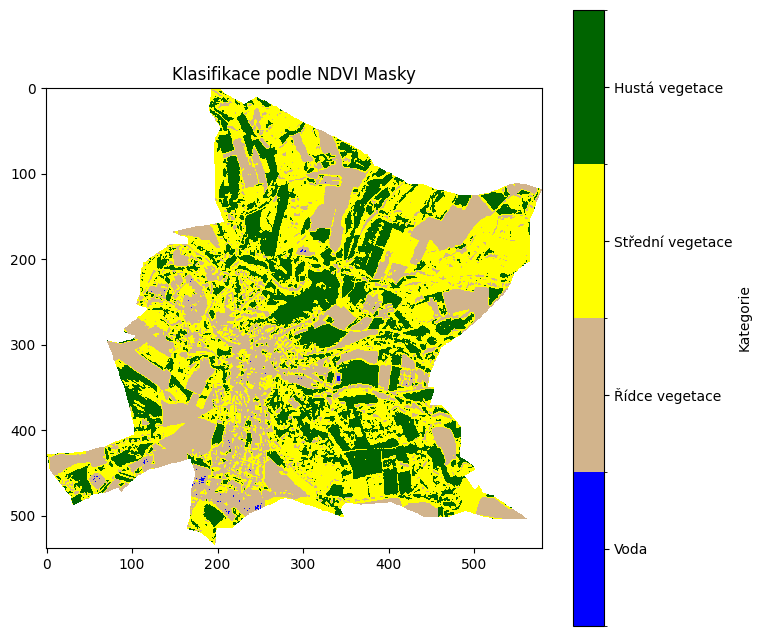

In [302]:

# Předpokládané data
rastr_klasifikace = labels_2d
# Definice masek pro různé oblasti podle NDVI
maska_voda = (NDVI >= -1) & (NDVI < 0)
maska_ridka_vegetace = (NDVI >= 0) & (NDVI < 0.3)
maska_stredni_vegetace = (NDVI >= 0.3) & (NDVI < 0.5)
maska_husta_vegetace = (NDVI >= 0.5) & (NDVI <= 1)

# Úprava klasifikovaného rastrového obrazu na základě NDVI
# Přiřazení hodnot z NDVI na základě masky
# Například pro oblast s vodou nastavíme klasifikaci na 0 (můžete si přizpůsobit hodnoty podle potřeby)
rastr_klasifikace[maska_voda] = 0  # Voda
rastr_klasifikace[maska_ridka_vegetace] = 1  # Řídce vegetace
rastr_klasifikace[maska_stredni_vegetace] = 2  # Střední vegetace
rastr_klasifikace[maska_husta_vegetace] = 3  # Hustá vegetace

# Vytvoření diskrétní colormap pro klasifikaci
colors = ['blue', 'tan', 'yellow', 'darkgreen']  # Barvy pro různé oblasti
cmap = ListedColormap(colors)

# Normalizace pro zobrazení
norm = BoundaryNorm(boundaries=np.arange(5)-0.5, ncolors=5)

# Vykreslení mapy s barvami pro každý klastra a typ pokrytí
plt.figure(figsize=(8,8))
plt.imshow(rastr_klasifikace, cmap=cmap, norm=norm)

# Přidání colorbaru a titulu
cbar = plt.colorbar(label='Kategorie', ticks=[0, 1, 2, 3])
cbar.set_ticklabels(['Voda', 'Řídce vegetace', 'Střední vegetace', 'Hustá vegetace'])
plt.title('Klasifikace podle NDVI Masky')
plt.show()
